#Video Game Sales with Ratings
*Cas kaggle*

Gerard Benet Martínez - 1704125
Javier Emparan López - 1704634

---

## Definició del problema

Aquest projecte se centra en l'anàlisi predictiva de les ventes de videojocs, utilitzant una base de dades que integra una àmplia col·lecció de títols amb les seves mètriques de qualitat extretes principalment de la plataforma Metacritic. A partir d'aquesta, l'objectiu és crear un regressor capaç de predir les ventes d'un joc tant a nivell global com per a les diferents regions. Per aconseguir això, hem de desenvolupar un model que pugui generalitzar les diferents tendències i les característques que causen que un joc vengui bé en cada una d'aquestes. En aquest cas kaggle:

- S'analitzaran les dades i es realitzarà un preprocessat d'aquestes per a potenciar el futur entrenament del model. En aquest preprocessament, s'eliminaràn els nans presents a la base de dades, s'escalaràn els atributs amb un escalador que es seleccionarà prèviament i es realitzarà un encoding de variables categòriques.
- S'entrenarà un regressor del tipus XGB amb les dades obtingudes del preprocessament. Aquest procés és realitzarà mitjançant pipelines per evitar el data leakage i aconseguir que els resultats siguin el més realistes possibles. També s'utilitzarà una GridSearch per a provar diferents combinacions d'hiperparàmetres possibles.
- Es validaràn els resultats del model mitjançant validació creuada i s'analitzarà el seu rendiment final.

Cal destacar que s'han provat bastants altres tipus de models, l'ús de regularitzadors per a models lineals i altres mètriques de validació entre altres coses.
Això ho explicarem amb més detall en cada un dels apartats, però es pot apreciar amb més profunditat en diferents punts del git. Per exemple, en una branca alternativa hem provat a fer funcionar models lineals, o en versions anteriors d'aquesta hem utilitzat altres tipus de models no lineals.

---

A continuació tenim l'importació de les diferents llibreries que s'usaràn en el projecte, juntament amb la del dataset de video game sales que s'usarà.


In [ ]:
#importacio de llibreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

from xgboost import XGBRegressor

import kagglehub

In [ ]:

# Importacio de les dades directament de Kaggle
path = kagglehub.dataset_download("rush4ratio/video-game-sales-with-ratings")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/Video_Games_Sales_as_at_22_Dec_2016.csv")

Using Colab cache for faster access to the 'video-game-sales-with-ratings' dataset.
Path to dataset files: /kaggle/input/video-game-sales-with-ratings


## Visualització de les dades
En aquesta primera part fem una visualització inicial de les dades per a tenir una millor comprensió del problema i saber com afrontar-lo apropiadament. Analitzarem els diferents atributs i veurem com estàn representats a les bases de dades, així com possibles biaixos que aquests puguin tenir.

In [ ]:
#Funcions auxiliars per a la visualització de les dades
#Permet mostrar la quantitat de NaNs del dataset en forma de gràfic de barres
def mostrarGraficNaNs(dades):
  nan_counts_all = dades.isnull().sum()

  if not nan_counts_all.empty:
      plt.figure(figsize=(12, 6))

      nan_counts_all.plot(kind='bar', color='darkorange')

      plt.title('Quantitat de missing Values (NaN) per atribut', fontsize=16)
      plt.xlabel('Atributs', fontsize=12)
      plt.ylabel('Quantitat de NaNs', fontsize=12)

      for i, v in enumerate(nan_counts_all):
          plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

      plt.xticks(rotation=45, ha='right')
      plt.grid(axis='y', linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


In [ ]:
print('Visualització del dataset:')
print(df)
print('--------------------------------------------------------------------------\n')
print("Nombre d'atributs:", len(df.columns))
print('Descripció dels atributs: ')
print(df.describe(include='all'))
print('--------------------------------------------------------------------------\n')
print('Informació sobre els NaNs dels atributs: ')
print(df.info())

Visualització del dataset:
                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA           2003.0      Platform   
16718            Winning Post 8 2016      PSV           2016.0    Simulation   

          Pu

A partir d'aquesta informació, podem extreure bastantes dades importants. Veiem que el dataset compta amb 16719 jocs que tenen 16 atributs, alguns d'ells categòrics i altres numèrics, tant discrets com contínus. Un mateix joc pot estar vàries vegades a la base de dades si ha sortit a vàries plataformes, com és el cas de 'Need for Speed: Most Wanted', que surt 12 cops.

Hem determinat que els atributs categòrics són els següents:
Name, Plataforma, Genre, Publisher, Developer, Rating

També que els atributs numèrics són els següents:
- Discrets: Year_of_Release, Critic_Count, User_Count
- Continus: Critic_Score, User_Score, i tots els de ventes

És essencial entendre què representen aquests atributs per al seu correcte tractament, escalat i interpretació.

A continuació una breu descripció dels diferents atributs:
- Name: Nom del joc. Gràcies a aquest atribut, podem saber que la base de dades cobreix un total de 11562 jocs diferents, és a dir, que 5157 entrades són versions per a diferents plataformes.
- Plataforma: Nom de la plataforma en la que ha sortit el joc. Hi han un total de 31 plataformes diferents representades, essent la que té més jocs la PS2, amb 2161 jocs.
- Genre: Gènere del joc (esports, carreres, puzzles...). Els jocs es classifiquen en 12 gèneres diferents, i el més freqüent és el d'acció que representa 3370 jocs.
- Publisher: Nom de l'empresa encarregada de la publicació i distribució del joc. Hi han un total de 581 empreses diferents, entre les quals destaca EA amb el nombre màxim de jocs distribuits, 1356.
- Developer: Nom de l'empresa encarregada de desenvolupar el joc. Aquest camp té molts més valors únics, 1696, entre els que destaquen Ubisoft amb 204 jocs desenvolupats.
- Rating: Edat mínima recomanada. Segueix un format d'etiquetes basat en el ESRB. Tot i haver només 8 etiquetes diferents segons aquesta classificació, destaca que la més popular és la 'E' de Everyone (+6 anys recomanats). Hem notat que hi han ratings 'RP', rating pending, que s'hauríen de tractar com a NaNs, i 'K-A', que era l'antiga forma de referir-se al rating 'E' i que haurien de transformar-se en aquest segon.
- Year_of_Release: Any de llançament del joc. Es pot apreciar com aquest valor va desde el 1980 fins al 2020, però la mitjana es troba entre els anys 2006 i 2007. Per tant, hi hauràn més jocs de la segona meitat cap a endevant. Els percentils donen encara més informació, ja que revelen que la majoría de jocs es concentren en el periòde comprès entre els anys 2000-2010.
- Critic_Count: Nombre de ressenyes de crítics verificats. El joc més ressenyat per la crítica compta amb 113 ressenyes, però el nombre de crítiques per joc es concentra en un punt més al voltant de les 20-30.
- User_Count: Nombre de ressenyes de usuaris. El nombre de valoracions dels usuaris per joc és bastant major que el de la crítica. La majoría de jocs no tenen moltes valoracions, promitjant les 10-30, però uns quants jocs disparen la mitja amb fins a 10665 valoracions.
- Critic_Score: Mitjana de les valoracions de la crítica en una escala del 0 al 100. La mitjana de notes que posa la crítica giren entorn al 7 i solen concentrar-se en l'interval superior del rang.
- User_Score: Mitjana de les valoracions dels usuaris en una escala del 0 al 10. No es poden extreure moltes dades d'aquest camp ja que bastants dels seus valors són 'tbd', és a dir, 'to be determined'. Això requerirà un tractament addicional que els converteixi en NaNs.
- Global_Sales: Nombre total de ventes del joc a nivell global en escala de milions.
- NA_Sales: Nombre total de ventes del joc a Amèrica del nord en escala de milions.
- EU_Sales: Nombre total de ventes del joc a Europa en escala de milions.
- JP_Sales: Nombre total de ventes del joc a Japó en escala de milions.
- Other_Sales: Nombre total de ventes del joc a altres regions del món en escala de milions.

Tots aquests valors de ventes estàn definits per molts factors relacionats als mercats de les diferents regions, tendències regionals i temporals i campanyes de màrketing entre d'altres. El que es pot extreure d'aquests camps és el entendre que cada mercat té una escala diferent que afectarà a les ventes de cada joc en la regió. No es pot esperar que un joc vengui una quantitat similar a Japó que a tota Europa, encara que sigui un èxit en les dues regions.
Addicionalment, analitzant els percentils es pot apreciar com hi han molts jocs que venen molt poc, però molts pocs que venen desenes de milions. Aquesta no linealitat en les ventes és un dels reptes que haurem de superar a l'hora de realitzar prediccions.

A continuació, hem realitzat un anàlisi dels NaNs del dataset en cada un dels atributs. La presència de NaNs pot generar soroll i empitjorar la precisió del model, de manera que és important conèixer la seva presència i proporció per a realitzar-ne un tractament correcte.

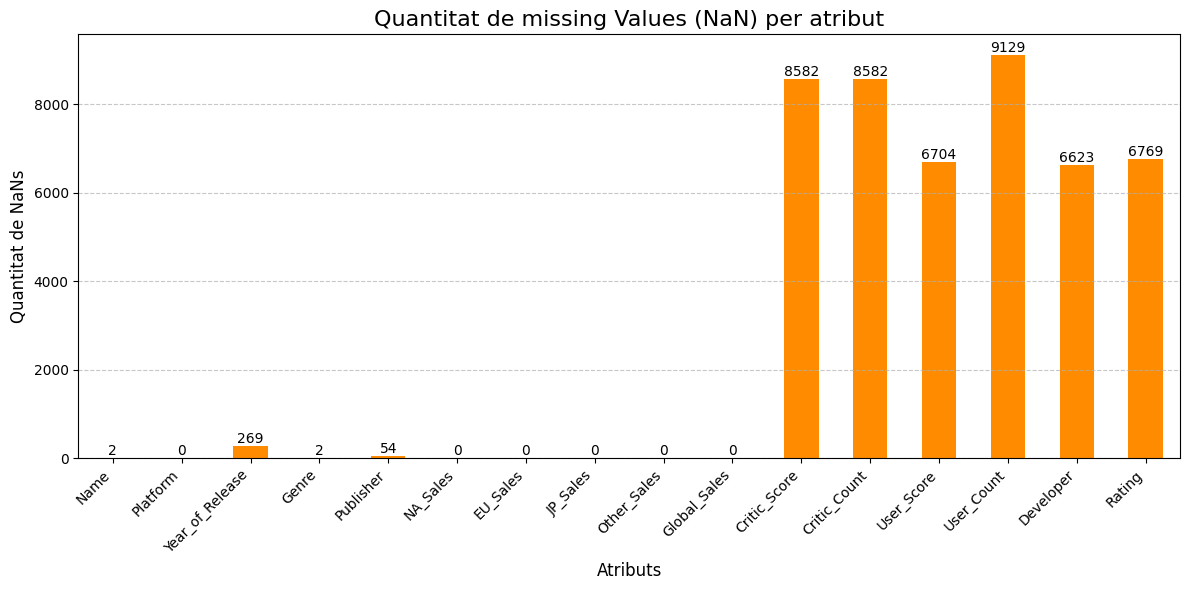

In [ ]:
mostrarGraficNaNs(df)

Podem destacar que hi ha una gran quantitat de NaNs en les categories de valoracions (critic/user score i critic/user count), a més de la categoria Developer i rating. També podem veure una petita quantitat de NaNs en l'any de publicació i en el publisher del joc. Finalment, tant el gènere com el nom tenen un parell de NaNs.

Al haver una quantitat tant dràstica de NaNs en alguns dels atributs, en alguns casos rondant el 50%, no podem optar per eliminar les entrades que els contenen. Per tant, no ens queda més remei que omplir-los amb una estratègia d'imputació que ens permeti reduír el màxim possible el soroll que aquests generen.

---
## Preprocessament de dades

En aquesta part es dissenyarà i durà a terme un preprocessament de les dades. Aquest serà idèntic al que s'utilitzarà per al model final, de manera que podrem visualitzar millor els resultats d'aplicar cada pas d'aquest preprocessament. Tot i ser idèntic, el preprocessament del model es farà amb pipelines per tal d'aconseguir un resultat més robust i compacte.

Per començar el preprocessament definirem quins atributs del dataset son categòrics i quins són numèrics, utilitzant l'informació extreta de l'apartat anterior. Això ens permetrà fer un tratament més adequat de les dades i adaptar-les satisfactòriament per al model.

També descartarem altres atributs, Name i Developer. Aquest primer ja que serveix com a identificador dels diferents jocs, però a no ser que es realitzi un tractament massa exhaustiu com el buscar paraules claus o franquícies de jocs dins d'ell, no aportarà gran informació. L'atribut de developer es descartarà ja que comparteix molta informació amb el publisher, i no és tant important com aquest últim ja que no s'encarrega de la publicitat del joc. Addicionalment, com hem vist a l'apartat anterior, Developer compta amb molts NaNs que perjudicarien al model i generarien soroll.

Name el descartarem més endevant ja que el necessitem per identificar els jocs, el que és essencial per a algunes parts posteriors del preprocessament, però Developer el descartarem ara.

In [ ]:
#inicialitzacio de dades importants
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Platform','Rating','Publisher', 'Genre']

dfPrep = df.drop(columns='Developer')

---
### Tractament de NaNs

Per una part, com hem vist a la part de visualització de dades, la columna "User_Score" es considerada categorica ja que conté dades "to be determined". Aquestes dades les tractarem com NaNs per poder tractarles mes endavant correctament amb la resta de missing values.

Una vegada tractats els "tbd" podem veure que la quantitat de valoracions de usuaris encaixa amb la seva respectiva quantitat de scores.

De manera similar, farem el mateix amb els ratings. Com hem comentat abans, hem de convertir els 'RP' en NaNs i, ja que estem, els 'K-A' en 'E' per a adaptar-nos a l'etiquetatge ESRB.

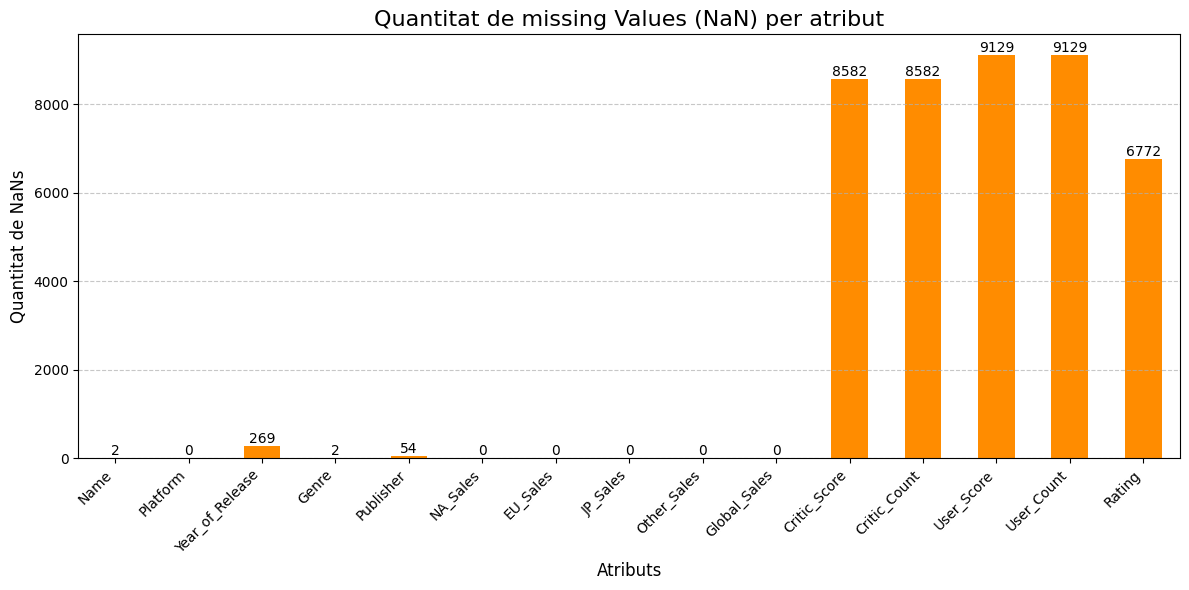

In [ ]:
dfPrep['User_Score'] = dfPrep['User_Score'].replace('tbd', np.nan) #Transforma TBD en NaNs
dfPrep['User_Score'] = pd.to_numeric(dfPrep['User_Score']) #Converteix la columna en float
dfPrep['Rating'] = dfPrep['Rating'].replace('RP', np.nan) #Transforma RP en NaNs
dfPrep['Rating'] = dfPrep['Rating'].replace('K-A', 'E') #Transforma K-A en E
df_fixed = dfPrep
mostrarGraficNaNs(df_fixed)


Una vegada fet aixó, podem començar a procesar els NaNs. Hem decidit utilitzar una barreja d'estratègies d'imputació per a intentar adaptar-nos a la naturalesa de les dades. Cal destacar que aquesta part del preprocessament difereix lleugerament amb la que realitzarem finalment en l'entrada del model. Per el moment, utilitzarem un IterativeImputer per a omplir els NaNs dels atributs numèrics i un SimpleImputer que utilitzi la moda pels categòrics.

Més endavant usarem un mètode similar, però, com que en el cas dels camps rating i publisher usarem un OrdinalEncoder, podrem usar el IterativeImputer en comptes del SimpleImputer invertint l'ordre del preprocessament en aquella pipeline concreta.

En ambdós casos, també generarem columnes auxiliars per a permetre al model saber si cada valor ha sigut generat artificialment o ja era present en la base de dades original.



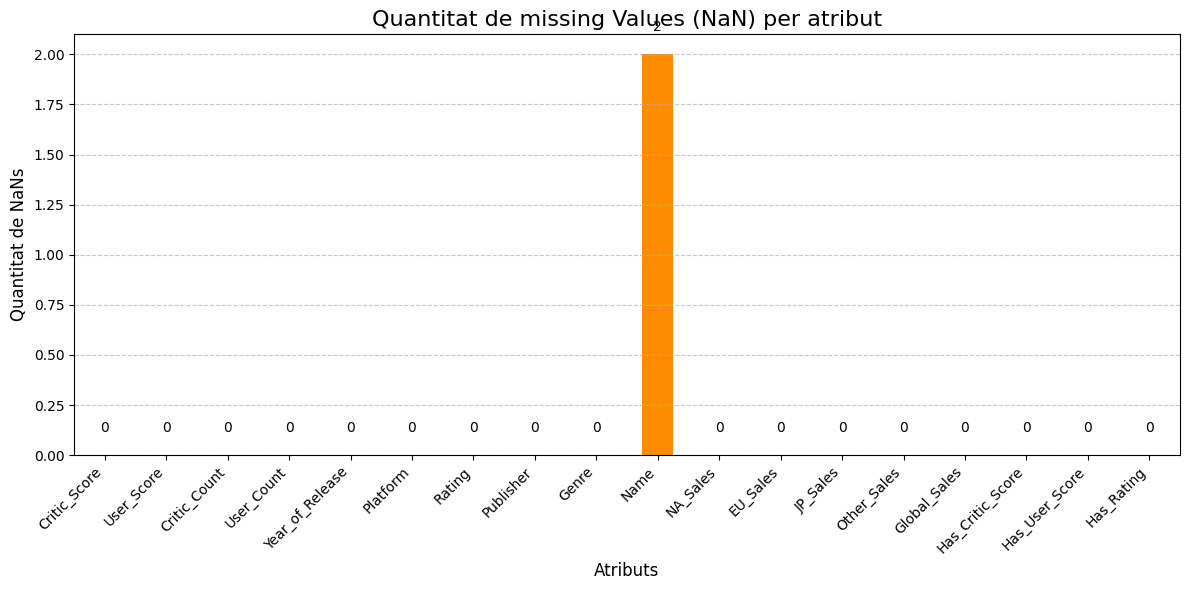

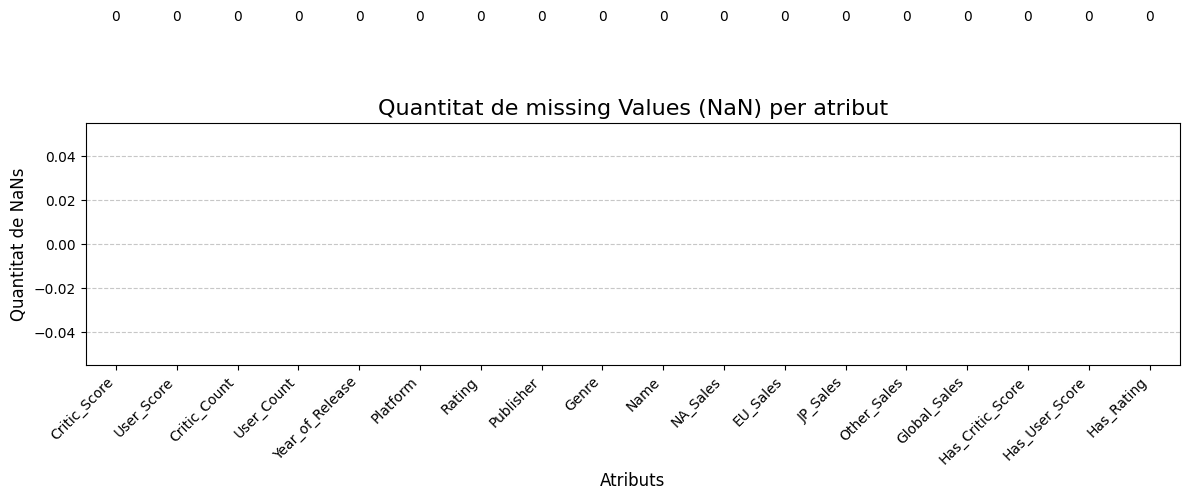

In [ ]:
df_fixed['Has_Critic_Score'] = df_fixed['Critic_Score'].notnull().astype(int)
df_fixed['Has_User_Score'] = df_fixed['User_Score'].notnull().astype(int)
df_fixed['Has_Rating'] = df_fixed['Rating'].notnull().astype(int)

numeric_imputed = IterativeImputer(max_iter=10, random_state=42, min_value=0).fit_transform(df_fixed[numeric_features])
df_numeric = pd.DataFrame(numeric_imputed, columns=numeric_features, index=df.index)

categorical_imputed = SimpleImputer(strategy='most_frequent').fit_transform(df_fixed[categorical_features])
df_categorical = pd.DataFrame(categorical_imputed, columns=categorical_features, index=df.index)

passthrough_cols = [col for col in df_fixed.columns if col not in numeric_features + categorical_features]
df_passthrough = df_fixed[passthrough_cols]

df_imputed = pd.concat([df_numeric, df_categorical, df_passthrough], axis=1)

mostrarGraficNaNs(df_imputed)

df_imputed = df_imputed.dropna()

mostrarGraficNaNs(df_imputed)


---
### Data scaling
A continuació es realitzarà un procés d'escalat de les dades numèriques.
Aquest procés ha perdut una mica el propòsit ja que, el model que usarem finalment, un arbre de decisió, no es beneficia de tenir dades normalitzades.
Tot i això, hem decidit deixar-lo intacte ja que tampoc afecta negativament a la seva capacitat predictiva i ha sigut útil per a provar altres models com les svm.

Com es pot veure a continuació, les dades numèriques del problema estàn desproporcionades:

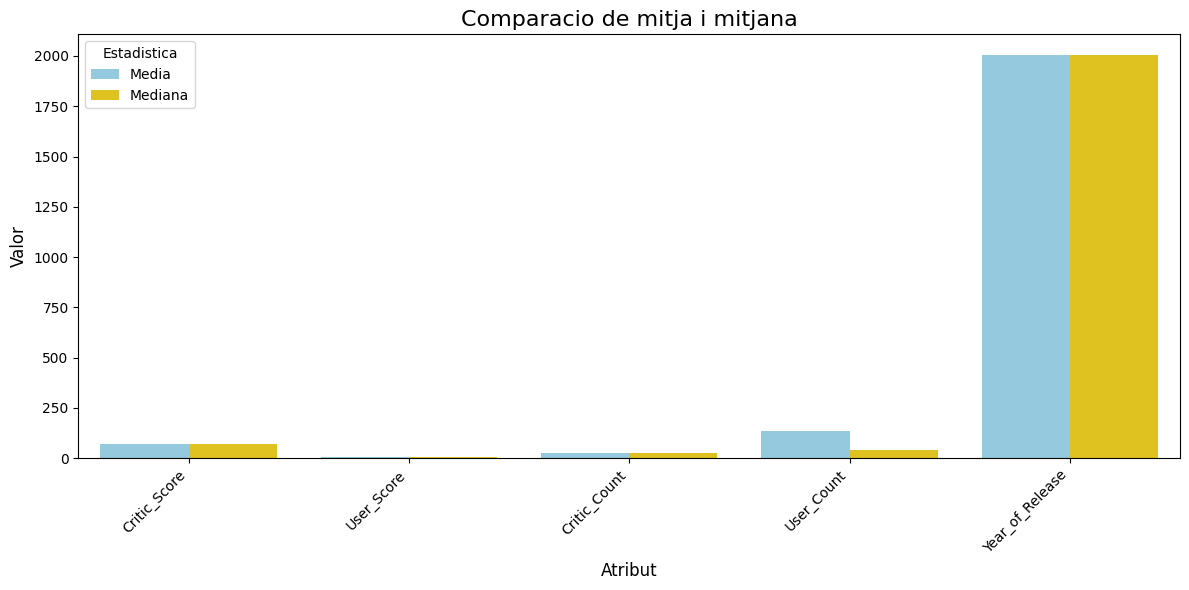

In [ ]:
df2 = df_imputed[numeric_features]
# -----------------------------------------------------
medias = df2[numeric_features].mean().rename('Media')
medianas = df2[numeric_features].median().rename('Mediana')

df_stats = pd.concat([medias, medianas], axis=1)

df_plot = df_stats.reset_index().melt(
    id_vars='index',
    var_name='Estadística',
    value_name='Valor'
)

df_plot = df_plot.rename(columns={'index': 'Atributo'})

plt.figure(figsize=(12, 6))

sns.barplot(
    x='Atributo',
    y='Valor',
    hue='Estadística',
    data=df_plot,
    palette={'Media': 'skyblue', 'Mediana': 'gold'}
)
plt.title('Comparacio de mitja i mitjana', fontsize=16)
plt.xlabel('Atribut', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Estadistica')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Abans d'escalar les dades utilitzant un scaler, hem fet una mica de normalització manual de les dades. Per reduir l'escala de l'any de llançament dels jocs, hem optat per restar a cada valor de l'atribut 1980, és a dir, el seu valor mínim. D'aquesta manera, el domini de l'atribut que abans era [1980-2020] passa a ser [0-40].

També hem multiplicat per 10 l'user score, ja que les valoracions de la crítica estaven puntuades entre el 0 i el 100 mentre que les dels usuaris entre el 0 i el 10. Amb aquest ajust simple, les dues mètriques són ara directament comparables.

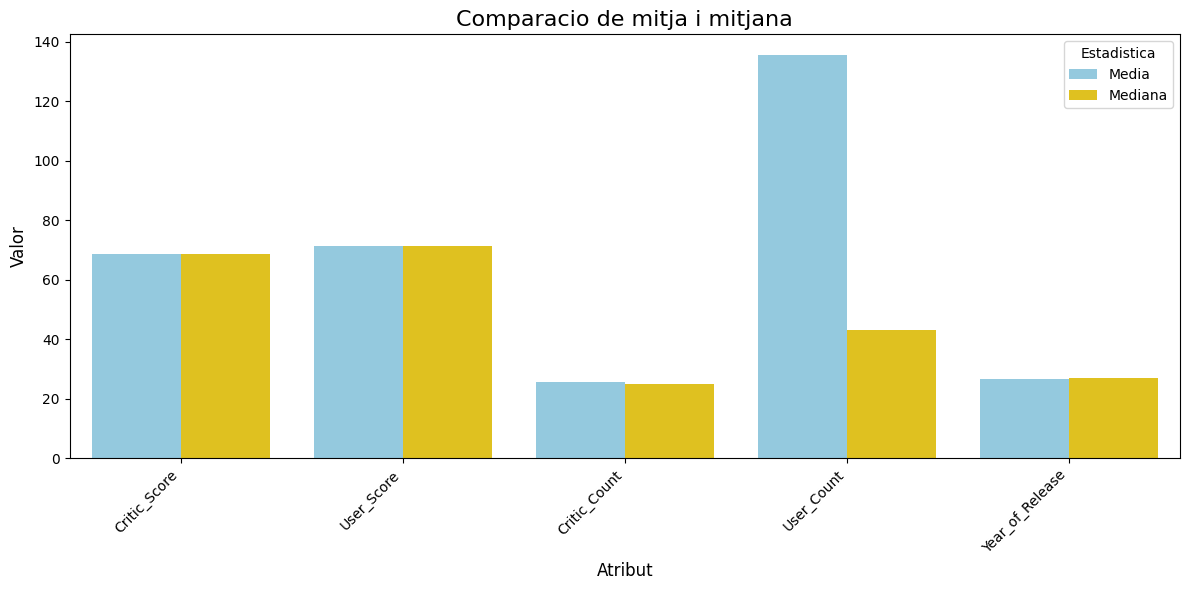

In [ ]:
df2.loc[:, 'Year_of_Release'] = df2['Year_of_Release'] - 1980 #El joc més antic de la base de dades és del 1980
df2.loc[:, 'User_Score'] = df2['User_Score'] * 10


#----------------------------------------------------------------------------
medias = df2[numeric_features].mean().rename('Media')
medianas = df2[numeric_features].median().rename('Mediana')

df_stats = pd.concat([medias, medianas], axis=1)

df_plot = df_stats.reset_index().melt(
    id_vars='index',
    var_name='Estadística',
    value_name='Valor'
)

df_plot = df_plot.rename(columns={'index': 'Atributo'})

plt.figure(figsize=(12, 6))

sns.barplot(
    x='Atributo',
    y='Valor',
    hue='Estadística',
    data=df_plot,
    palette={'Media': 'skyblue', 'Mediana': 'gold'}
)
plt.title('Comparacio de mitja i mitjana', fontsize=16)
plt.xlabel('Atribut', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Estadistica')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Finalment, per evitar el biaix de caracteristiques i millorar la convergencia mes endavant quan començem a entrenar els models, probarem diferents scalers per veure quin normalitza millor els atributs.

- L'StandardScaler centra les dades a 0 (restant la mitjana) i ajusta la variància. Va bé per a dades que segueixen una distribució normal (campana), però els outliers (valors extrems) el distorsionen.

- El MinMaxScaler comprimeix totes les dades estrictament entre 0 i 1. Manté les distàncies relatives, però si tens un sol valor extrem molt gran, la resta de dades queden "aixafades" contra el 0.

- El RobustScaler utilitza la mediana i el rang interquartil en lloc de la mitjana. Ignora els extrems, fent-lo el millor escalador per a dades com les nostres (vendes de videojocs) on hi ha pocs jocs que venen moltíssim i molts que venen poc.

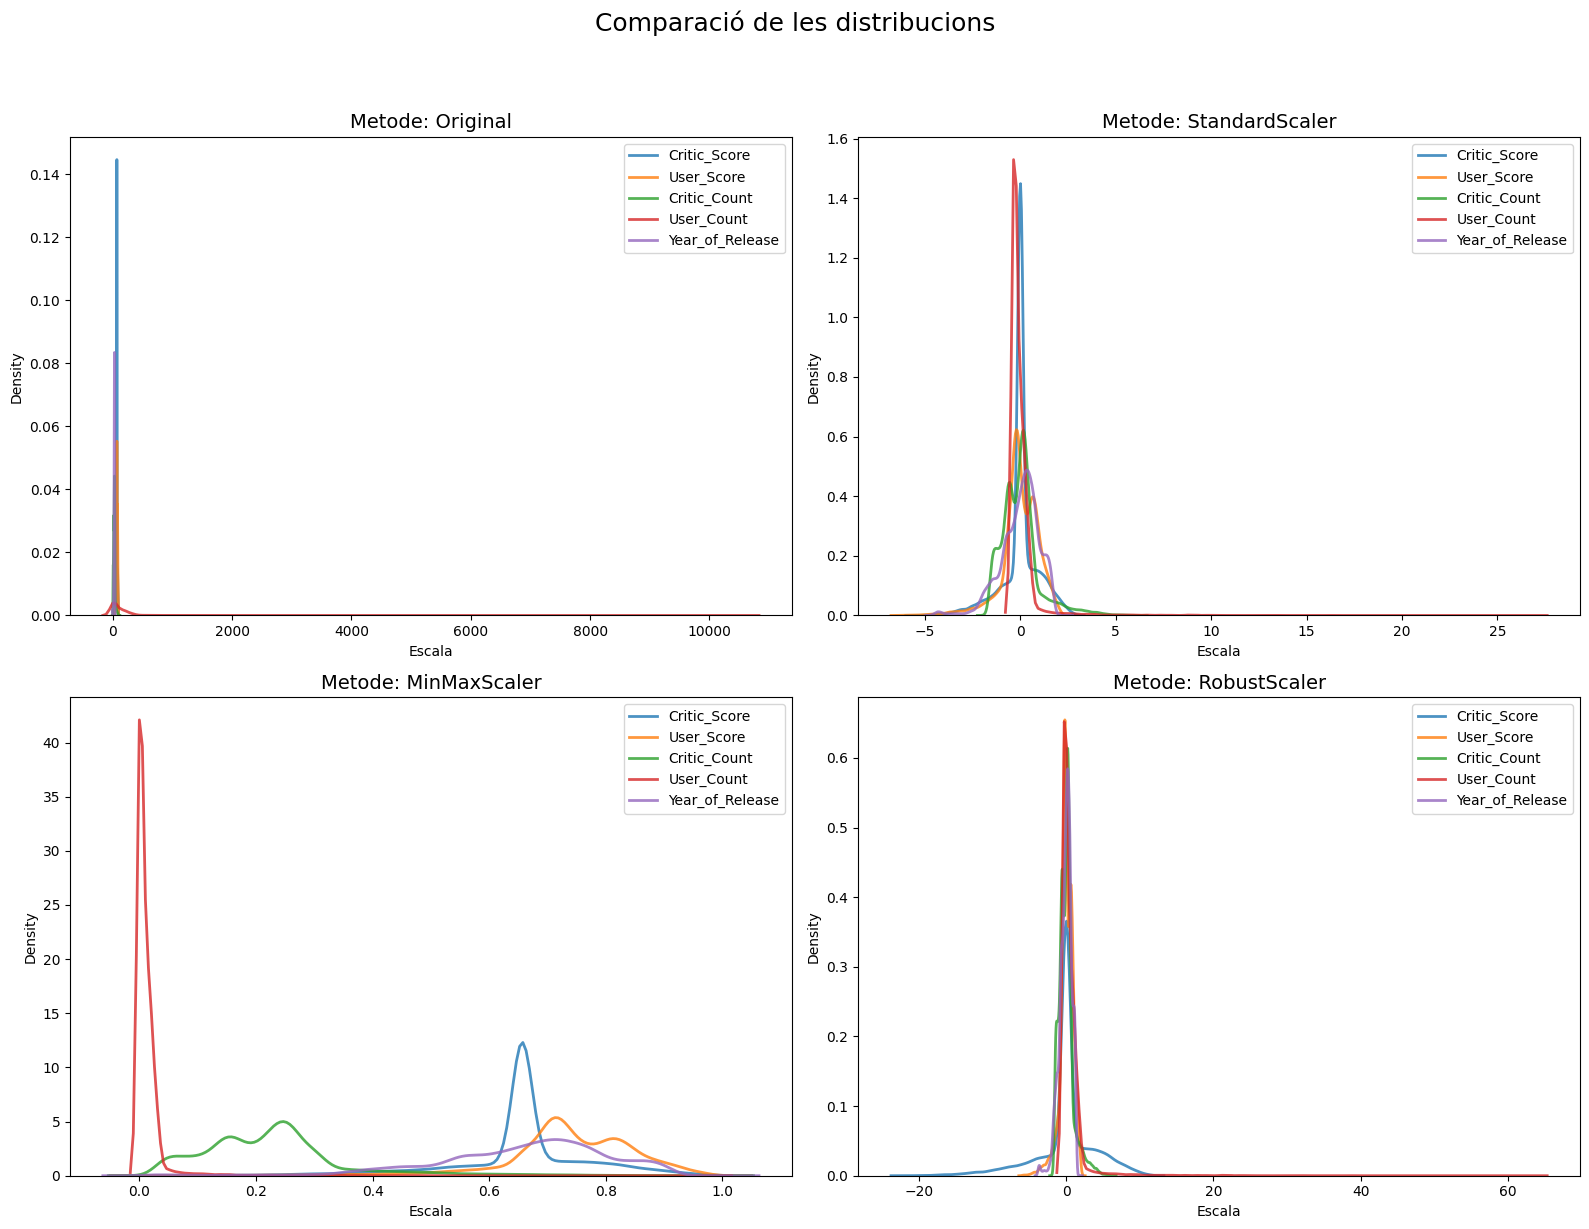

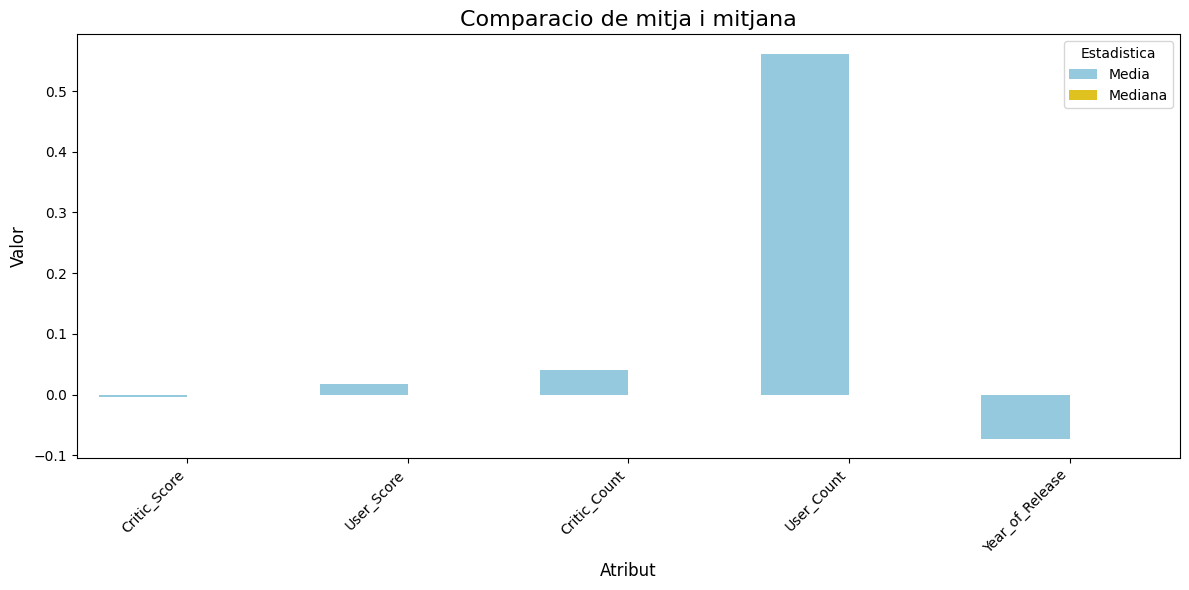

In [ ]:
scalers = {
    "Original": df2.copy(),
    "StandardScaler": pd.DataFrame(StandardScaler().fit_transform(df2), columns=numeric_features, index=df2.index),
    "MinMaxScaler": pd.DataFrame(MinMaxScaler().fit_transform(df2), columns=numeric_features, index=df2.index),
    "RobustScaler": pd.DataFrame(RobustScaler().fit_transform(df2), columns=numeric_features, index=df2.index)}

plt.figure(figsize=(16, 12))
plt.suptitle('Comparació de les distribucions', fontsize=18, y=1.02)

for i, (name, scaled) in enumerate(scalers.items(), 1):
    plt.subplot(2, 2, i)
    for col in numeric_features:
         sns.kdeplot(scaled[col], fill=False, label=col, alpha=0.8, linewidth=2)

    plt.title(f'Metode: {name}', fontsize=14)
    plt.xlabel('Escala')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

df_scaled = df_imputed.copy()
df_scaled[numeric_features] = scalers["RobustScaler"]

#----------------------------------------------------------------------------
medias = scalers["RobustScaler"].mean().rename('Media')
medianas = scalers["RobustScaler"].median().rename('Mediana')

df_stats = pd.concat([medias, medianas], axis=1)

df_plot = df_stats.reset_index().melt(
    id_vars='index',
    var_name='Estadística',
    value_name='Valor'
)

df_plot = df_plot.rename(columns={'index': 'Atributo'})

plt.figure(figsize=(12, 6))

sns.barplot(
    x='Atributo',
    y='Valor',
    hue='Estadística',
    data=df_plot,
    palette={'Media': 'skyblue', 'Mediana': 'gold'}
)
plt.title('Comparacio de mitja i mitjana', fontsize=16)
plt.xlabel('Atribut', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Estadistica')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



Com hem comentat abans i vist amb les dades, el millor escalador per al nostre problema és el RobustScaler, ja que és el menys afectat per els outliers.

---
### Tractament de dades categóriques


Per una altra banda, també hem de tractar els atributs categorics previament mencionats. Per a que el model els pugui processar correctament, els hem de codificar d'una manera adecuada.

Si mirem la quantitat de valors unics per cada atribut, podem veure que en developer y publisher hi ha una gran quantitat de valors unics. Codificar aquests amb un encoder del tipus label, ordinal o onehot pot donar problemes. Per solventar aixó, hem decidit tenir en compte únicament els publishers i descartar els developers. Això ja que els dos aporten informació molt similar però els publishers estàn més relacionats amb la distribució del producte. Addicionalment, els developers tenen molts més valors únics i NaNs, de manera que generarien molt més soroll.
Ara bé, per codificar els publishers hem decidit crear 5 categories en funció de la quantitat de jocs publicats, que després es codificaràn amb un ordinal encoder. Utilitzarem el mateix encoder pel rating, classificant-lo en les 6 etiquetes del sistema ESRB.

Per ultim, hem decidit aplicar un onehot encoder al genere del joc i a la plataforma, ja que no hi havien tants possibles valors i altres encoders li atribuien a aquests camps un valor semàntic incorrecte.

A continuació veiem la quantitat de valors únics per als diferents atributs categòrics a codificar:

In [ ]:
columnas_categoricas = categorical_features

for columna in columnas_categoricas:
    valores_unicos = df_scaled[columna].unique()

    print(f"\nAtribut: {columna}")
    print(f"Nombre de valors unics: {len(valores_unicos)}")
    print(f"Valors unics: {valores_unicos[:10]}")

    if len(valores_unicos) > 20:
        print(f"Hi ha mes de 20!")


Atribut: Platform
Nombre de valors unics: 31
Valors unics: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4']
Hi ha mes de 20!

Atribut: Rating
Nombre de valors unics: 6
Valors unics: ['E' 'M' 'T' 'E10+' 'AO' 'EC']

Atribut: Publisher
Nombre de valors unics: 581
Valors unics: ['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Bethesda Softworks'
 'Electronic Arts' 'Sega' 'SquareSoft']
Hi ha mes de 20!

Atribut: Genre
Nombre de valors unics: 12
Valors unics: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting']


En aquest codi es classifica la columna Publisher en els 5 tamanys possibles, com hem explicat anteriorment. Es crea la columna Publisher_Tier_Safe amb la nova classificació i després es descarta l'original:

In [ ]:
publisher_counts = df_scaled.groupby('Publisher')['Name'].transform('count')

def classify_by_count(count):
    if count >= 1000:
        return 'Gegant'
    elif count >= 600:
        return 'Gran'
    elif count >= 300:
        return 'Mitja'
    elif count >= 50:
        return 'Petit'
    else:
        return 'Molt petit'

df_scaled['Publisher_Tier_Safe'] = publisher_counts.apply(classify_by_count)

# --- Resultados ---
print("Exemple de les primeres files:")
print(df_scaled[['Publisher', 'Publisher_Tier_Safe']].head(5))
print("\nQuantitat de Publishers per Tier:")
print(df_scaled['Publisher_Tier_Safe'].value_counts())
print("-" * 60)

df_scaled = df_scaled.drop(columns='Publisher')

Exemple de les primeres files:
  Publisher Publisher_Tier_Safe
0  Nintendo                Gran
1  Nintendo                Gran
2  Nintendo                Gran
3  Nintendo                Gran
4  Nintendo                Gran

Quantitat de Publishers per Tier:
Publisher_Tier_Safe
Gran          6437
Petit         3968
Molt petit    3379
Mitja         1523
Gegant        1410
Name: count, dtype: int64
------------------------------------------------------------


Aquí es realitza el procés d'encoding mencionat anteriorment. Com es pot apreciar, el Rating i el Publisher utilitzen un OrdinalEncoder per mantenir la cardinalitat mentre que Genre i Platform es codifiquen directament amb un OneHotEncoder:

In [ ]:
#ORDINAL ENCODER
#Rating
rating_categories = [['EC', 'E', 'E10+', 'T', 'M', 'AO']]

ordinal_encoder = OrdinalEncoder(categories=rating_categories)
rating_column = df_scaled[['Rating']]
rating_encoded_array = ordinal_encoder.fit_transform(rating_column)
df_scaled['Rating'] = rating_encoded_array.flatten()

#Publisher
tier_categories = [['Molt petit', 'Petit', 'Mitja', 'Gran', 'Gegant']]

ordinal_encoder = OrdinalEncoder(categories=tier_categories)
publisher_column = df_scaled[['Publisher_Tier_Safe']]
rating_encoded_array = ordinal_encoder.fit_transform(publisher_column)
df_scaled['Publisher_Tier_Safe'] = rating_encoded_array.flatten()


#ONEHOT ENCODER
cols_to_encode = ['Genre', 'Platform']
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = onehot_encoder.fit_transform(df_scaled[cols_to_encode])
new_cols = onehot_encoder.get_feature_names_out(cols_to_encode)
df_encoded = pd.DataFrame(
    encoded_array,
    columns=new_cols,
    index=df_scaled.index
)
df_scaled = pd.concat([df_scaled.drop(cols_to_encode, axis=1), df_encoded], axis=1)

print(df_scaled.columns)


Index(['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count',
       'Year_of_Release', 'Rating', 'Name', 'NA_Sales', 'EU_Sales', 'JP_Sales',
       'Other_Sales', 'Global_Sales', 'Has_Critic_Score', 'Has_User_Score',
       'Has_Rating', 'Publisher_Tier_Safe', 'Genre_Action', 'Genre_Adventure',
       'Genre_Fighting', 'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle',
       'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy', 'Platform_2600',
       'Platform_3DO', 'Platform_3DS', 'Platform_DC', 'Platform_DS',
       'Platform_GB', 'Platform_GBA', 'Platform_GC', 'Platform_GEN',
       'Platform_GG', 'Platform_N64', 'Platform_NES', 'Platform_NG',
       'Platform_PC', 'Platform_PCFX', 'Platform_PS', 'Platform_PS2',
       'Platform_PS3', 'Platform_PS4', 'Platform_PSP', 'Platform_PSV',
       'Platform_SAT', 'Platform_SCD', 'Platform_SNES', 'Platform_TG16',
       'Platform_WS', 'Platform_Wii', 'Platform_WiiU', 'Platform

Finalment es descarta la columna Name pels motius que hem comentat a l'inici de l'apartat i es tornen a visualitzar les dades, per veure que tot estigui correctament codificat:

In [ ]:
df_scaled = df_scaled.drop(columns='Name')

print('Visualització del dataset:')
print(df_scaled)
print('--------------------------------------------------------------------------\n')
print("Nombre d'atributs:", len(df.columns))
print('Descripció dels atributs: ')
print(df_scaled.describe(include='all'))
print('--------------------------------------------------------------------------\n')
print('Informació sobre els NaNs dels atributs: ')
print(df_scaled.info())

Visualització del dataset:
       Critic_Score  User_Score  Critic_Count  User_Count  Year_of_Release  \
0          2.860546    0.738412      1.874871    1.689146        -0.142857   
1          0.606715    1.615572     -1.229321   -0.260334        -3.142857   
2          5.235876    0.991895      3.461300    4.032154         0.142857   
3          4.444099    0.738412      3.461300    0.902088         0.285714   
4          0.137202    0.790075     -0.634757   -0.260334        -1.571429   
...             ...         ...           ...         ...              ...   
16714      0.074884   -0.672445      0.727706    1.852773         1.285714   
16715     -0.074884    0.050299     -0.018605    0.314513        -0.142857   
16716      0.074884   -0.672445      0.727706    1.852773         1.285714   
16717     -0.119814    0.267123     -0.242498   -0.146965        -0.571429   
16718      0.074884   -0.672445      0.727706    1.852773         1.285714   

       Rating  NA_Sales  EU_Sales  J

---
## Selecció de mètriques
Una vegada preprocesades les dades, seleccionem la millor mètrica per poder avaluar el problema. Hem de tenir en compte el tipus de dades que tenim i, sobretot, la seva distribució.

En aquest cas, el nostre dataset té una distribució en la que la majoría de jocs venen per sota del milió de còpies, mentre que uns pocs arriben a les desenes de milions. Això, lògicament, crea mitjanes poc realistes i molts jocs que tenen el nombre de ventes molt disparats, el que afectarà a la capacitat predictiva del model.

Hem considerat diferents mètriques d'avaluació, com ara MSE, MAE, R2 o fins i tot RMSE.

Finalment, i després de vàries proves, ens hem quedat amb el model que minimitza MAE. Això ja que els resultats són més consistents i, a més, el MAE és una mètrica que no es veu molt afectada per els outliers, el que és un requisit essencial en el nostre cas.
Les mètriques de MSE i R2 donàven valors lleugerament pitjors, i la RMSE donava exactament els mateixos valors en la majoría de casos, però resultats menys consistents en les ventes globals.

---
## Selecció del model
Per poder seleccionar el model que s'adaptés millor al problema, hem provat diverses opcions.

La primera opció que hem provat han sigut models lineals. Donada la naturalesa de les dades, encara que hem provat a aplicar regularitzadors i a intentar adaptar el preprocessament de les dades per a simplificar-les, no ha donat bons resultats. Fins i tot, hem provat a calcular el logarítme de les ventes en comptes de les propies ventes tal i com després fariem en la resta de models, però els resultats han sigut els pitjors amb diferència.

Després hem provat amb una svm. Aplicant algunes tècniques com ara la de calcular el logaritme han millorat bastant els resultats.

Aquest mètode, però, ha tingut dos principals inconvenients. El primer i que més ens ha afectat ha sigut el llarg temps d'ajustament que tenen aquests models. Aquest temps ha fet que l'execució del codi passés d'un minut i poc a mitja hora, el que ha complicat el procés de testeig i ha limitat molt el nombre de paràmetres que podiem provar al gridSearchCV.

L'altre problema ha sigut que no hi havia cap kernel que anés especialment bé per aquest problema. Un dels principals punts forts de les svm és l'ús dels kernels per a separar les dades, però en aquest cas la naturalesa logarítmica de les nostres dades afectava negativament a la majoría de kernels, i d'altres disparaven el temps d'execució encara més. El millor kernel era rbf, però tot i així els resultats eren molt semblants als aconseguits amb el model final.

Per a intentar mitigar aquests inconvenients hem provar a utilitzar arbres de decisió. Hem decidir optar per un ensemble basat en el boosting com és XGBRegressor, pensant que les prediccions del preu basades en fulles reduirien l'influència dels pocs jocs que venen milions i que disparen els errors en les prediccions.

Al ser un model més barat computacionalment, ens podem permetre ampliar el nombre de paràmetres a comprovar en el GridSearch respecte a la svm, el que també ha contribuit a rebre uns resultats una mica millors.

En resum, ens hem quedat amb aquest model ja que, en comparació amb altres, és més ràpid i ofereix uns resultats lleugerament millor, ja que s'adapta millor al problema que afrontem.

En el codi d'abaix creem classes que repeteixen el preprocessament vist anteriorment, però ara de forma més compacte. Això ho fem ja que el codi anterior era millor per il·lustrar un a un els passos del preprocessament, però per entrenar el model final hem decidit fer servir pipelines. D'aquesta manera, podem evitar el data leakage i aconseguir que el codi sigui més robust.

In [ ]:
#Funcions utils adaptades a l'api de sklearn, ja que les utilitzem en el pipelining. Realitzen un preprocesament manual d'alguns dels atributs.

numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
rating_feature = ['Rating']
binary_features = ['Has_Critic_Score', 'Has_User_Score', 'Has_Rating']
rating_categories = [['EC', 'E', 'E10+', 'T', 'M', 'AO']]
genre_platform_features = ['Genre', 'Platform']
publisher_feature = ['Publisher_Tier']
tier_categories = [['Molt petit', 'Petit', 'Mitja', 'Gran', 'Gegant']]

class UserScoreCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['User_Score'] = X['User_Score'].replace('tbd', np.nan) #Transforma TBD en NaNs
        X['User_Score'] = pd.to_numeric(X['User_Score']) #Converteix la columna en float
        X['Rating'] = X['Rating'].replace('RP', np.nan) #Transforma RP en NaNs
        X['Rating'] = X['Rating'].replace('K-A', 'E') #Transforma K-A en E

        X['Has_Critic_Score'] = X['Critic_Score'].notnull().astype(int)
        X['Has_User_Score'] = X['User_Score'].notnull().astype(int)
        X['Has_Rating'] = X['Rating'].notnull().astype(int)
        return X

class PublisherBinner(BaseEstimator, TransformerMixin): #Codifica els publishers
    def fit(self, X, y=None):
        self.publisher_counts_ = X['Publisher'].value_counts()
        return self

    def transform(self, X):
        X = X.copy()

        def classify(publisher):
            count = self.publisher_counts_.get(publisher, 0)
            if count >= 1000:
              return 'Gegant'
            elif count >= 600:
              return 'Gran'
            elif count >= 300:
              return 'Mitja'
            elif count >= 50:
              return 'Petit'
            else:
              return 'Molt petit'

        X['Publisher_Tier'] = X['Publisher'].apply(classify)
        X.loc[:, 'Year_of_Release'] = X['Year_of_Release'] - 1980 #El joc més antic de la base de dades és del 1980
        X.loc[:, 'User_Score'] = X['User_Score'] * 10
        cols_to_drop = [c for c in ['Name', 'Developer', 'Publisher'] if c in X.columns]
        X = X.drop(columns=cols_to_drop)
        return X


En aquesta funció apliquem els encoders, imputers i scalers i els acabem juntant en una pipeline final que es retorna com a paràmetre:

In [ ]:
def construir_preprocesador():
    """Define y ensambla todos los pasos de preprocesamiento en un solo Pipeline."""

    numeric_transformer = Pipeline(steps=[
        ('imputer', IterativeImputer(max_iter=10, random_state=42, min_value=0)),
        ('scaler', RobustScaler())
    ])

    rating_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder(categories=rating_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
        ('imputer', IterativeImputer(max_iter=10, random_state=42, min_value=0)),
    ])

    genre_platform_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    publisher_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder(categories=tier_categories)),
        ('imputer', IterativeImputer(max_iter=10, random_state=42, min_value=0))
    ])

    # --- Unim tot en un ColumnTransformer ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('rating', rating_transformer, rating_feature),
            ('genre_platform', genre_platform_transformer, genre_platform_features),
            ('tier', publisher_transformer, publisher_feature),
            ('flags', 'passthrough', binary_features)
        ],
        remainder='drop'
    )

    # --- Pipeline de Preprocessament Final ---
    full_preprocessor_pipeline = Pipeline(steps=[
        ('cleaner', UserScoreCleaner()),
        ('binner', PublisherBinner()),
        ('preprocessor', preprocessor)
    ])

    return full_preprocessor_pipeline

Finalment, aquesta funció ens permet entrenar el model per a predir un dels diferents atributs de ventes especificat com a paràmetre. S'eliminen les columnes de ventes i utilitzant la funció anterior, es genera la pipeline de preprocessament. Després crea el model i s'envolica en un TransformedTargetRegressor per a calcular el logaritme de les ventes en comptes de les propies ventes. Finalment, s'estableixen un hiperparàmetres que després es proven amb el gridSearchCV.

Un cop seleccionat el millor model segons el MAE, s'imprimeixen els resultats de la validació i el test, juntament amb algúns gràfics. Els dos primers gràfics són un mateix scatter plot amb dos nivells de zoom que representa la relació entre cada venta i la seva predicció, essent la diagonal marcada el punt d'equilibri l'ideal. Quan més agrupats estàn els punts respecte la diagonal, millors resultats.
El segon gràfic és un gràfic de barres que mostra la distribució dels residus:

In [ ]:
def entrenar_modelos_no_lineales(df, target_col, zoomlevel):
    """
    Ejecuta GridSearchCV para modelos de regresión NO lineales (SVR y XGBoost)
    y genera gráficos de evaluación.
    """
    print(f"--- Iniciando GridSearch (XGBOOST) para: {target_col} ---")

    # 1. Preparar datos
    sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
    X = df.drop(columns=sales_cols)
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Obtener el Preprocesador Completo (Asumido)
    # Se asume que 'construir_preprocesador()' gestiona las transformaciones de las características
    preprocessor_pipeline = construir_preprocesador()

    # 3. Seleccionar Modelo y Parámetros

    xgb = XGBRegressor(
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror' # El objetivo estándar funciona bien con datos logarítmicos
    )

    # 4. Envolver el XGBoost con TransformedTargetRegressor
    # Esto se encarga del log1p antes de entrenar y expm1 después de predecir
    model_wrapper = TransformedTargetRegressor(
        regressor=xgb,
        func=np.log1p,       # Transformación: log(1 + x)
        inverse_func=np.expm1 # Inversa: exp(x) - 1
    )

    # 5. Pipeline Final
    # Nota: El wrapper va al final del pipeline
    full_pipeline = Pipeline(steps=[
        ('preproc', preprocessor_pipeline),
        ('model', model_wrapper)
    ])

    param_grid = {
        'model__regressor__n_estimators': [100, 200, 300, 500],
        'model__regressor__learning_rate': [0.01, 0.05, 0.1],
        'model__regressor__max_depth': [3, 4, 5, 7],
        'model__regressor__subsample': [0.7, 0.9],
        'model__regressor__colsample_bytree': [0.7, 0.9],
        'model__regressor__gamma': [0.1, 0.2, 0.5, 1, 5, 10],
        'model__regressor__min_child_weight': [3, 5, 10, 20, 50]
    }


    # 5. Configurar y Ejecutar GridSearchCV
    grid_search = RandomizedSearchCV(
        estimator=full_pipeline,
        param_distributions=param_grid,
        n_iter=30,
        cv=3,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    print(f"Ejecutando GridSearch para XGBOOST...")
    grid_search.fit(X_train, y_train)

    # 6. Resultados (Métricas)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    # 7. Evaluación Final (Impresión de resultados)
    print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor MAE en Validación Cruzada: {abs(grid_search.best_score_):.4f}")
    print(f"MAE test: {test_mae:.4f}")
    print(f"MSE test: {test_mse:.4f}")
    print(f"RMSE test: {test_rmse:.4f}")
    print(f"R2 test: {test_r2:.4f}")

    # --- 8. GENERACIÓN DE GRÁFICOS SEABORN ---

    # Creamos un DataFrame para graficar
    results_df = pd.DataFrame({
        'Real': y_test,
        'Predicho': y_pred,
        'Residuo': y_test - y_pred # Residuo = Real - Predicho
    })

    plt.figure(figsize=(20, 6))

    # --- Gráfico 1: Valores Reales vs. Predichos escala completa ---
    plt.subplot(1, 3, 1) # 1 fila, 3 columnas, posición 1
    sns.scatterplot(x='Real', y='Predicho', data=results_df, alpha=0.4)

    # Línea perfecta de predicción (donde Real = Predicho)
    max_val = results_df[['Real', 'Predicho']].max().max()
    plt.plot([0, max_val], [0, max_val], 'r--', lw=2)

    plt.title(f'Escala completa: Real vs Predicho', fontsize=12)
    plt.xlabel('Real Sales')
    plt.ylabel('Predicted Sales')
    plt.grid(True, alpha=0.3)

    # --- Gráfico 2: Valores Reales vs. Predichos zoom ---
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='Real', y='Predicho', data=results_df, alpha=0.4, color='g')

    plt.plot([0, 5], [0, 5], 'r--', lw=2)

    # ZOOM
    plt.xlim(0.0, zoomlevel)
    plt.ylim(0.0, zoomlevel)

    plt.title(f'Zoom: Real vs Predicho', fontsize=12)
    plt.xlabel('Real Sales')
    plt.ylabel('Predicted Sales')
    plt.grid(True, alpha=0.3)

    # --- Gráfico 3: Distribución de Residuos ---
    plt.subplot(1, 3, 3) # 1 fila, 2 columnas, posición 2
    sns.histplot(results_df['Residuo'], bins=30, kde=True, color='skyblue')

    # Línea en Residuo = 0
    plt.axvline(x=0, color='red', linestyle='--')

    plt.title(f'Distribución de Residuos | XGBOOST', fontsize=14)
    plt.xlabel('Residuo (Error)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    plt.tight_layout() # Ajusta el layout para que no se superpongan
    plt.show() # Muestra los dos gráficos

    return best_model

Finalment, aquí es crida a la funció anterior un cop per cada target, de manera que el model s'entrena per als 5 tipus diferents de ventes:

Resultats per: Global_Sales
--- Iniciando GridSearch (XGBOOST) para: Global_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.3571
MAE test: 0.3796
MSE test: 3.3094
RMSE test: 1.8192
R2 test: 0.1983


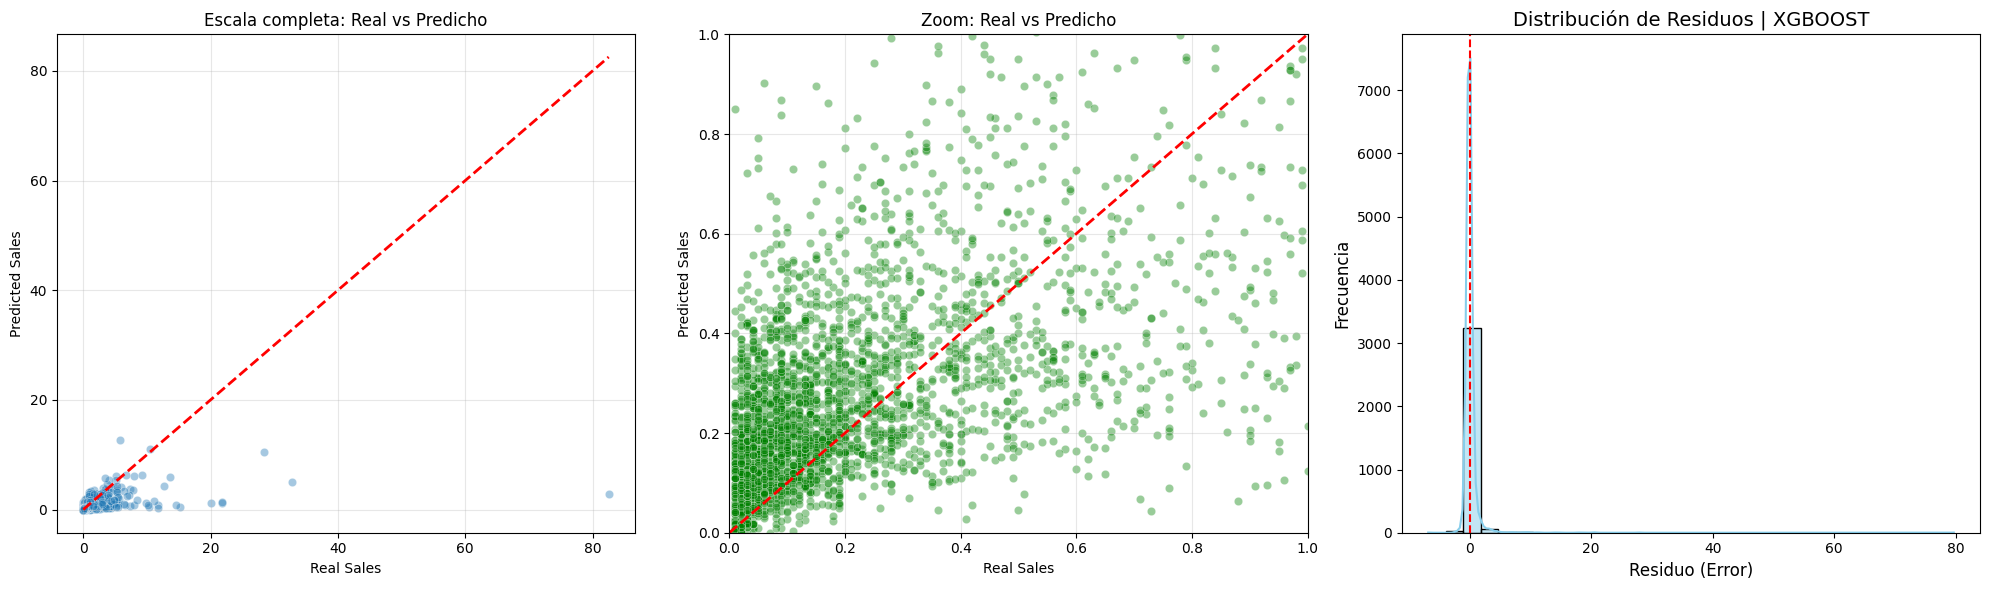

Resultats per: NA_Sales
--- Iniciando GridSearch (XGBOOST) para: NA_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.7, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 20, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.1, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.7}
Mejor MAE en Validación Cruzada: 0.1955
MAE test: 0.2043
MSE test: 0.8388
RMSE test: 0.9158
R2 test: 0.1867


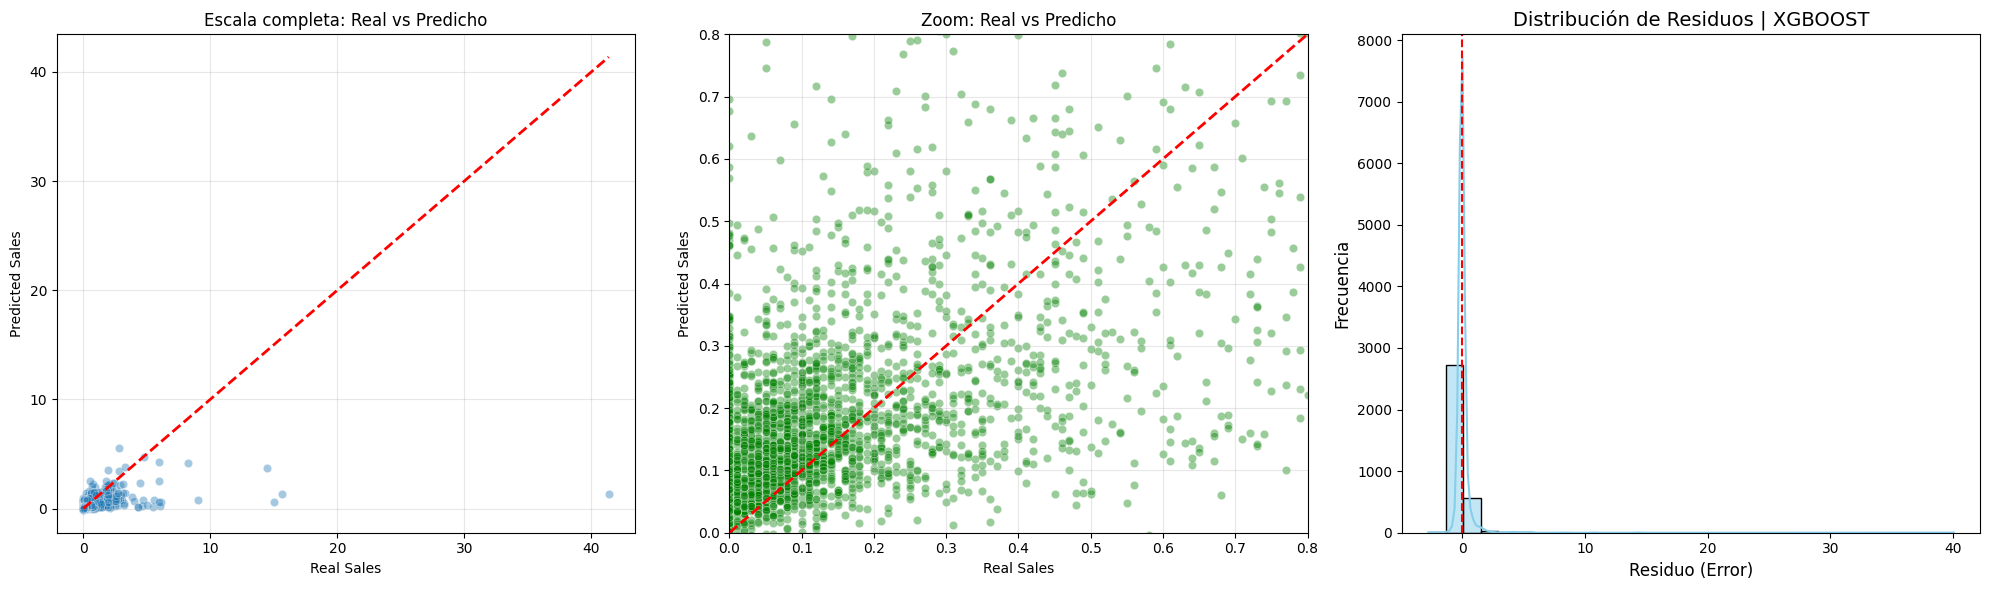

Resultats per: EU_Sales
--- Iniciando GridSearch (XGBOOST) para: EU_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.1226
MAE test: 0.1358
MSE test: 0.4117
RMSE test: 0.6417
R2 test: 0.1516


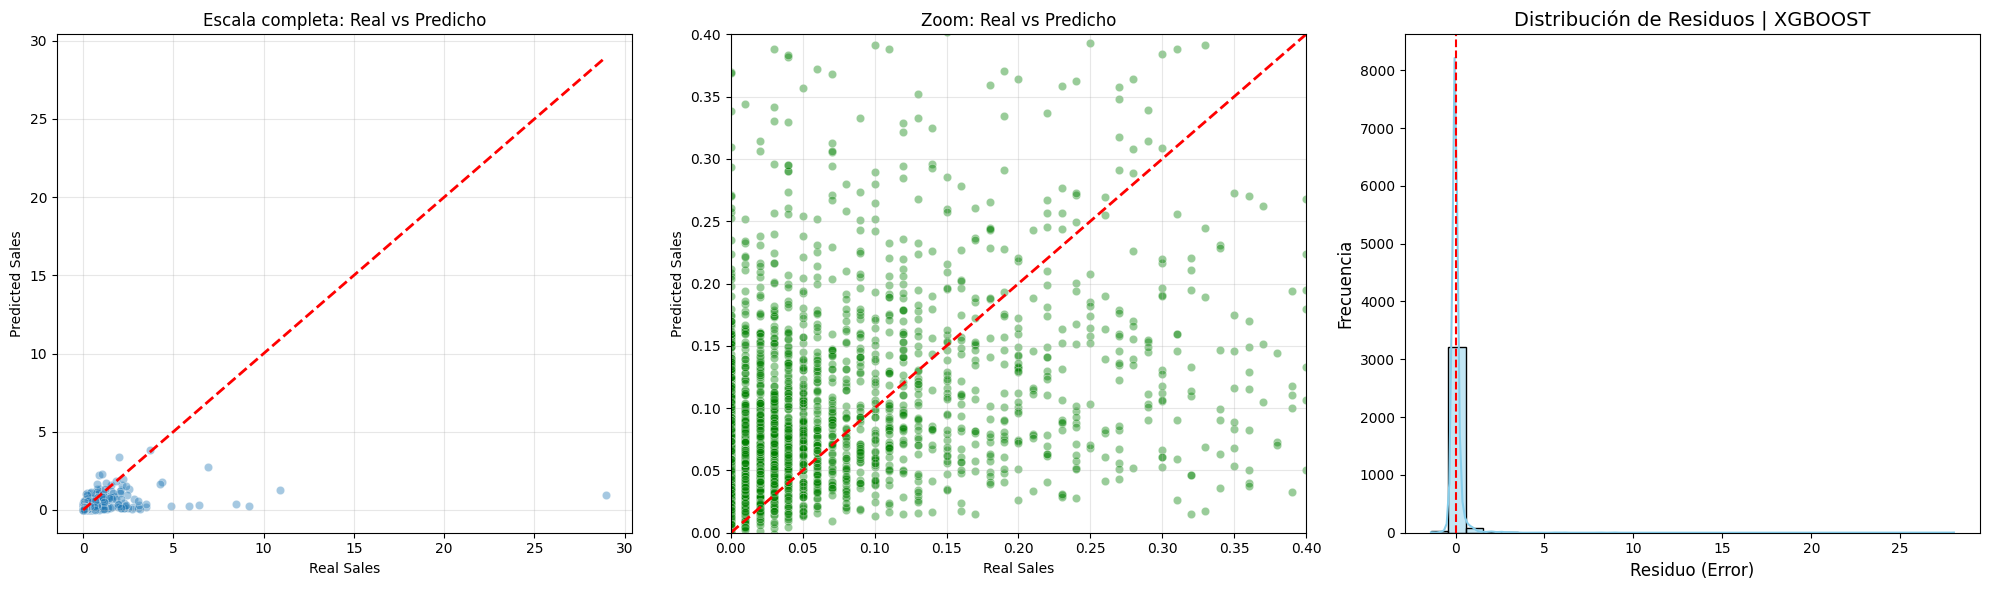

Resultats per: JP_Sales
--- Iniciando GridSearch (XGBOOST) para: JP_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.0763
MAE test: 0.0806
MSE test: 0.0732
RMSE test: 0.2706
R2 test: 0.2449


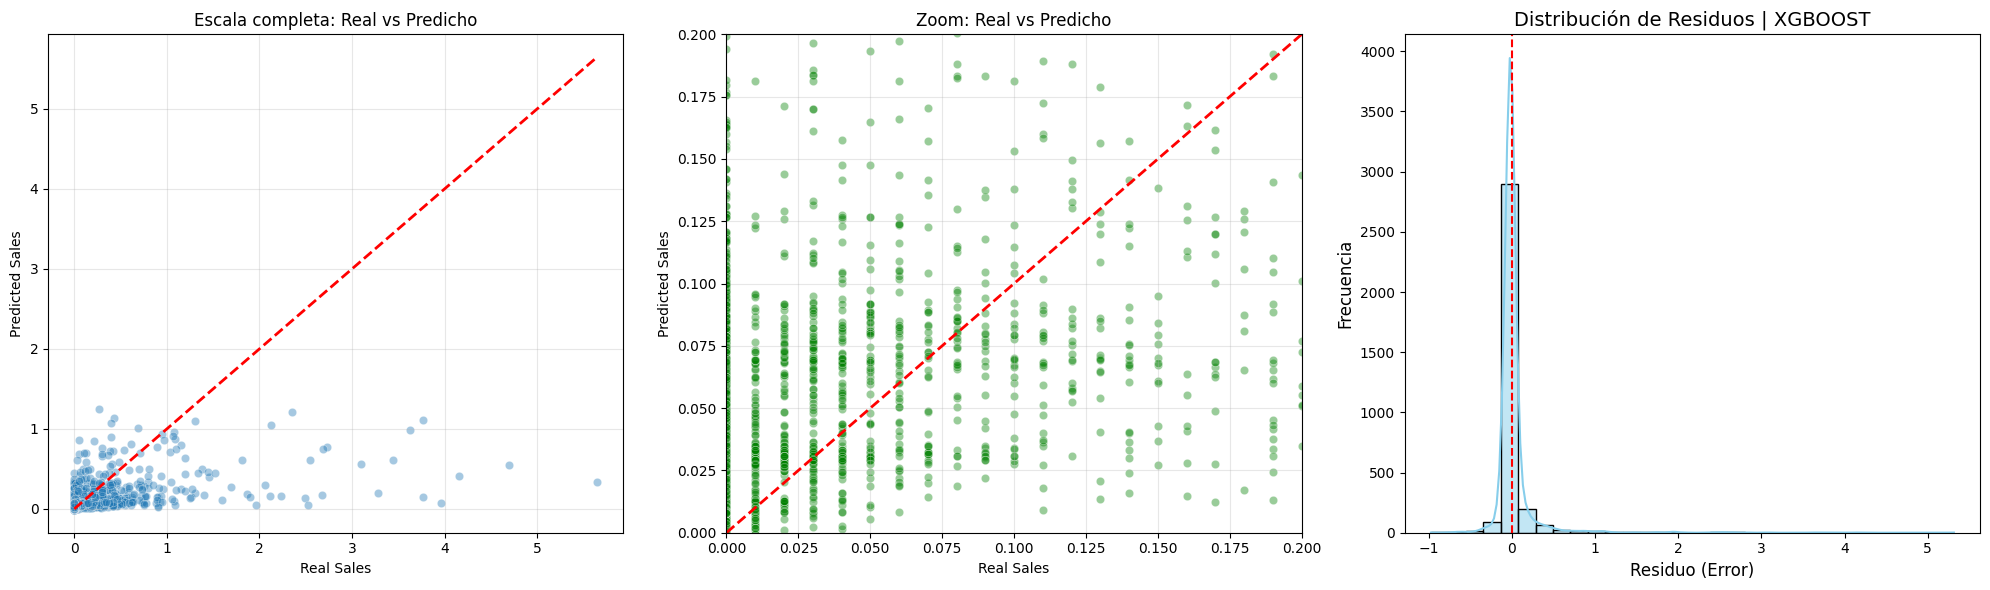

Resultats per: Other_Sales
--- Iniciando GridSearch (XGBOOST) para: Other_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.0410
MAE test: 0.0420
MSE test: 0.0347
RMSE test: 0.1862
R2 test: 0.2003


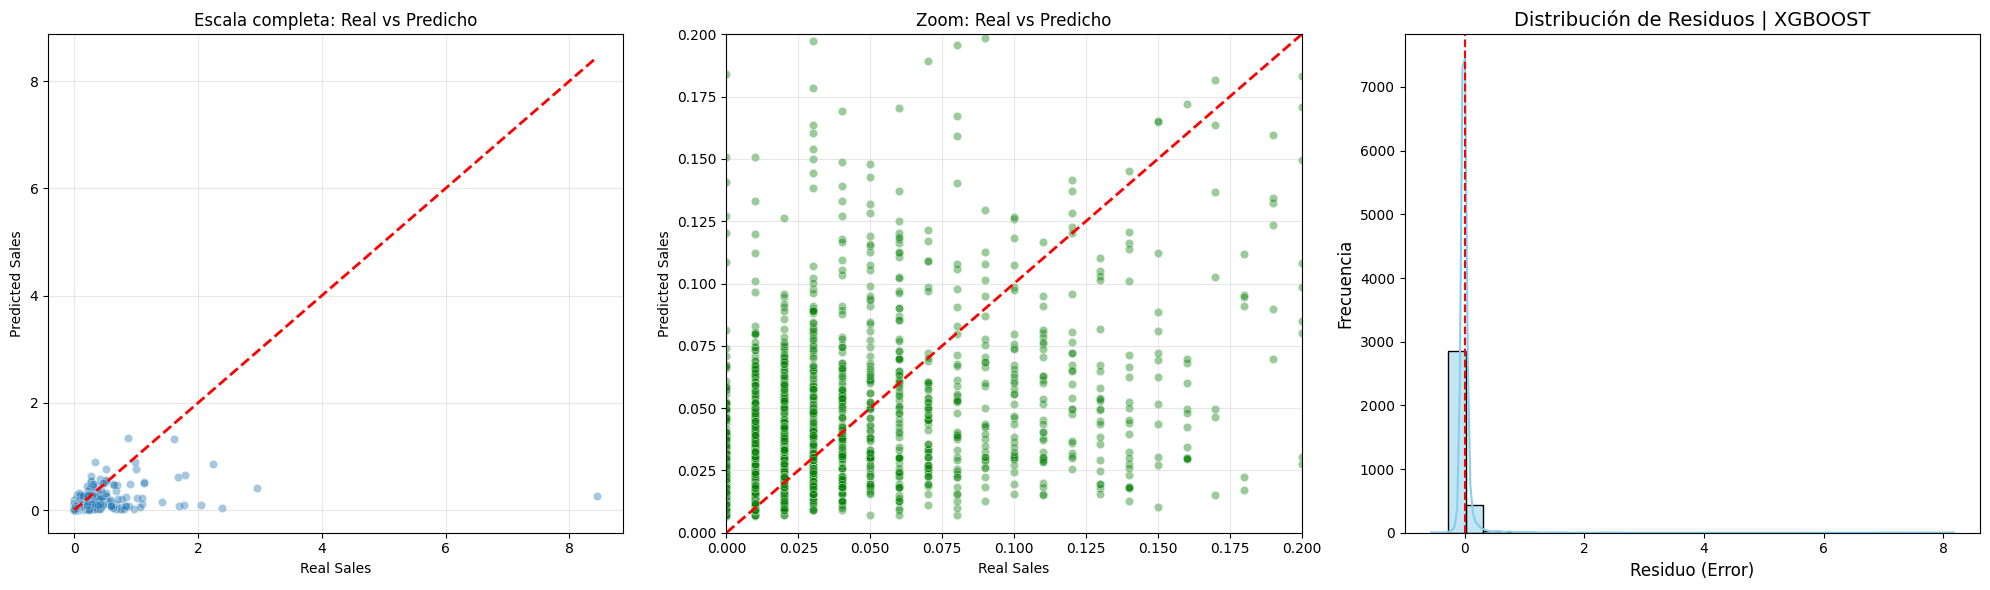

In [ ]:
targets = ['Global_Sales','NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
zoomlevels = [1.0, 0.8, 0.4, 0.2, 0.2]

for t in range(0, 5):
  print("Resultats per: " + targets[t])
  model_xgboost = entrenar_modelos_no_lineales(df, target_col=targets[t], zoomlevel=zoomlevels[t])

---
## Anàlisis final

La generalització de les dades per part del model ha presentat limitacions importants. El baix R2 demostra que el model només és capaç de predir aproximadament un 20% de la variança de les ventes. Això és raonable tenint en compte que aquestes depenen de molts altres factors, com ara campanyes publicitàries, tendències puntuals, el 'hype' comunitari i les popularitats de les diferents franquícies de videojocs establertes entre d'altres.

A més, alguns dels atributs de la base de dades han comptat amb una quantitat de NaNs propera al 50%, el que ha generat encara més soroll i ha empitjorat considerablement la precisió del model. Els imputers han permès mitigar aquest efecte, però, sense dubte, ha sigut determinant a l'hora d'entrenar el model.

Creiem, però, que el principal culpable de la moderada generalització del model ha sigut la variança en les dades.

El mercat dels videojocs, al ser relativament nou, ha crescut de manera desmesurada en les últimes dècades. En el 1980, els jocs venien molt menys que al 2020, i el tenir jocs repartits entre les dues dates ha condicionat al model, fent que aquest arribi a conclusions equivocades.

Addicionalment, el tenir jocs que venen desenes de milions i jocs que només venen desenes de milers en la mateixa base de dades ha causat que el model sigui lleugerament més optimista del que hauria a nivell general, com es pot apreciar en els gràfics del mig. Tot i això, el model no ha intentat predir cap tipus d'outlier i ha sigut bastant conservador en aquest aspecte, fent que algunes mètriques com la MSE es disparessin per culpa d'aquests.

A l'hora d'analitzar les mètriques de validació, cal recordar que aquestes es veuen condicionades per la escala de les regions. Un MAE de 0.2043 a Nord Amèrica, tot i ser més petit que el 0.3796 global, pot indicar una molt pitjor generalització considerant la relativitat de les escales.

Com es pot apreciar, tenint això en compte i analitzant les diferents mètriques de validació, la regió que millor ha generalitzat el model ha sigut la japonesa. Això segurament es deu a que el mercat japonès té tendències més marcades respecte a l'èxit dels videojocs i que es mantenen més en el temps.

Altres mercats com el Nord Americà, per exemple, són bastant més caòtics en aquest aspecte, el que ha provocat una pitjor generalització i una disminució en la precisió del model.

---
## Conclusions

Tot i els humils resultats que hem obtingut, creiem que el model és bastant bò donada la base de dades inicials. Considerem que aquesta base de dades ha sigut la principal limitació que hem enfrontat en aquest cas kaggle i estem segurs de que amb una quantitat major de dades i més completes, la capacitat predictiva del nostre model es dispararia.

Si haguessim tingut més dades, també haguessim fet un split del dataset basat en el any de publicació dels jocs. Creiem que aquest pas és essencial a l'hora de crear un model de predicció de preus i que això hagués reduit enormement la variança de les dades. Conseqüentment, això hagués permès al model arribar a conclusions més ajustades al context temporal de la publicació dels jocs, millorant moltíssim els resultats.

Tot i això, aquest cas kaggle ha sigut tot un repte que ens ha posat a prova. Hem hagut d'utilitzar tot el nostre coneixement i, fins i tot, investigar una mica més enllà per a poder aconseguir completar el projecte. La altíssima dificultat del repte ha sigut una sorpresa que no esperavem, ja que no s'ajustava a la vista en el full de càlcul de google que presentava els diferents reptes kaggle. Que els resultats fossin tant dolents al principi també ens va desmotivar bastant al principi, però poc a poc hem acabat construint un projecte del qual estem orgullosos.